In [1]:
#Install reproject package if not already installed
#pip install reproject

In [3]:
import sys
sys.argv[0]

'c:\\Users\\adipa\\anaconda3\\lib\\site-packages\\ipykernel_launcher.py'

In [18]:
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from astropy.utils.data import get_pkg_data_filename
from reproject import reproject_interp

In [19]:
# Open the xray FITS file
hdu_x = fits.open(get_pkg_data_filename('Data_Files/m51_xray.fits'))[0]

# Extract the data and the WCS
data_x = hdu_x.data
header_x = hdu_x.header
data_x = np.nan_to_num(data_x) # Replace NaN values with 0

invalid keyvalue. [astropy.wcs.wcs]


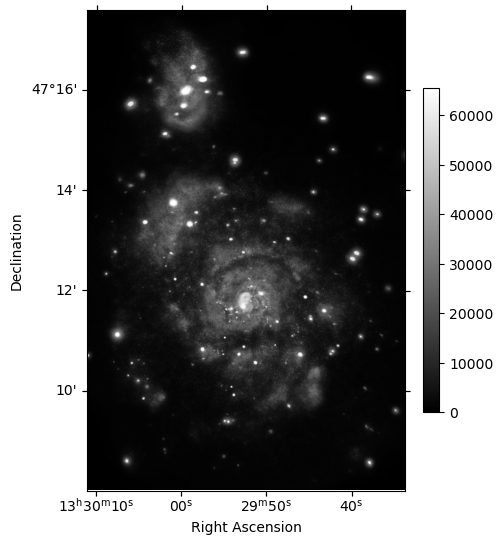

In [20]:
# Display the image
plt.figure(figsize=(10,10))
ax1 = plt.subplot(1,2,1,  projection=WCS(hdu_x.header))
im=ax1.imshow(data_x, origin='lower', cmap='gray')
ax1.coords['ra'].set_axislabel('Right Ascension')
ax1.coords['dec'].set_axislabel('Declination')
plt.colorbar(im, fraction=0.046)

### Importing Optical data
For the reprojection of the xray data to match the optical image, either the optical fits file with the WCS information or just the wcs file obtained from the astrometry.net webpage can be used.
The wcs file does not contain a data array and thus NAXIS information in its header is not present. This is why we need to define the new header manually. 

In [8]:
# Open the optical FITS file / wcs file
hdu_O = fits.open(get_pkg_data_filename('Data_Files/M51_wcs.fits'))[0]

# Extract the data and the WCS
data_O = hdu_O.data
header_O = hdu_O.header

if data_O == None:
    new_header = header_O.copy()
    new_header['NAXIS'] = 2 # Since it is a 2D image
    new_header['NAXIS1'], new_header['NAXIS2'] = new_header['IMAGEW'], new_header['IMAGEH'] # Set the dimensions same as the image height and width
else:
    new_header = header_O

In [27]:
# Display the image if the optical data is available
if data_O != None:
    plt.figure(figsize=(10,10))
    ax1 = plt.subplot(1,2,1,  projection=WCS(new_header))
    im=ax1.imshow(data_O, origin='lower', cmap='gray')
    ax1.coords['ra'].set_axislabel('Right Ascension')
    ax1.coords['dec'].set_axislabel('Declination')
    plt.colorbar(im, fraction=0.03)

### Reprojection of the xray data
The xray data is reprojected to match the optical image. `reproject_interp` function of the `repoject` library is used for this purpose. This function takes the xray data HDU ((array, WCS) or (array, Header)) and the wcs information of the optical image as input parameters and returns the reprojected xray array and its footprint. The footprint is the area of the reprojected array that is covered by the original array. Values of 0 indicate no coverage or valid values in the input image, while values of 1 indicate valid values.

In [30]:
# Reproject the xray data to the optical data
array, footprint = reproject_interp(hdu_x, new_header)

invalid keyvalue. [astropy.wcs.wcs]


### Plotting the reprojected xray data

Text(0.5, 1.0, 'X-ray image footprint')

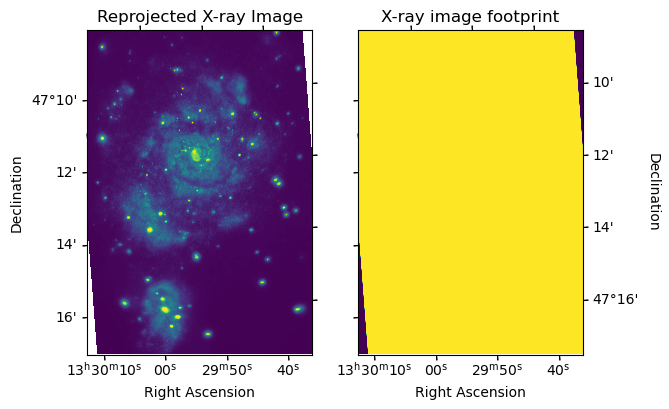

In [33]:
# The reprojected image and the footprint

ax1 = plt.subplot(1,2,1, projection=WCS(new_header))
ax1.imshow(array, origin='lower')
ax1.coords['ra'].set_axislabel('Right Ascension')
ax1.coords['dec'].set_axislabel('Declination')
ax1.set_title('Reprojected X-ray Image')

ax2 = plt.subplot(1,2,2, projection=WCS(new_header))
ax2.imshow(footprint, origin='lower')
ax2.coords['ra'].set_axislabel('Right Ascension')
ax2.coords['dec'].set_axislabel('Declination')
ax2.coords['dec'].set_axislabel_position('r')
ax2.coords['dec'].set_ticklabel_position('r')
ax2.set_title('X-ray image footprint')

### Saving the reprojected xray data
The reprojected xray data is saved as a fits file. The header of the reprojected xray data is updated with the wcs information of the optical image.

In [14]:
fits.writeto('Data_Files/Reprojected_Xray.fits', array, new_header, overwrite=True)